In [41]:
import re
import random
import pandas as pd
import hashlib

In [42]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].mean() > 80: age_factor = .5
else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.05

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [43]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
"Jane Eyre, Bronte",102.232843,12.779105,19.948442,8
Azure Functions + Visual Studio,183.302345,61.100782,138.975655,3
Azure AD Authentication,446.213695,37.184475,107.037332,12
Email Auth and Security,454.270216,56.783777,135.489446,8
Logging in Python,459.925845,32.851846,75.867239,14
RAG Project,785.530400,78.553040,221.464838,10
Debugging in VS Code,912.112706,82.919337,211.486494,11
Azure Private DNS,969.286449,51.015076,123.777029,19
C# Basics,1135.861795,36.640703,108.205630,31
Azure Functions + PP365,1426.804192,67.943057,193.804114,21


# Histogram

sum of ages: ~34941.62


<Axes: >

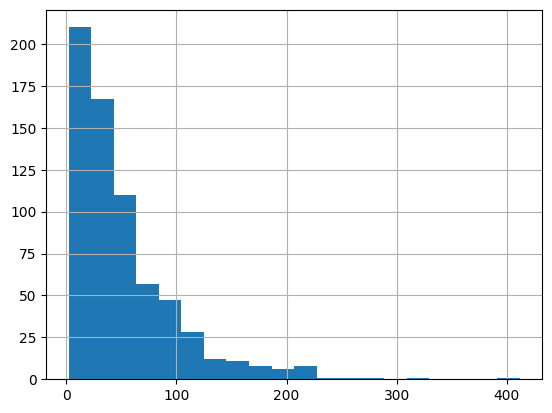

In [44]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~34941.62


<Axes: >

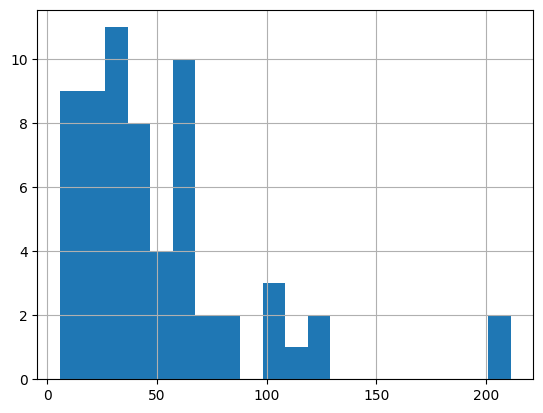

In [45]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure Developer Associate']['age'].hist(bins=20)

# Completely Random Shuffle

In [46]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [47]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [48]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

## Headers with greatest age sum first

In [49]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)
# existing_cards.head(10)

## Header with oldest cards first

In [50]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Focus on one header

In [51]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Headers with greatest mean card age first

In [52]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [53]:
# n=3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [54]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [55]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [56]:
n=5
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 669
Total card age: 34941.62


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
225,Azure Functions + Visual Studio,ASP.NET Web API is a framework for building HT...,8778d1d9428fa841dd48d609cb8ba53f,138.975655,61.100782,138.975655,183.302345,0.623978,3,0,0,-138.975655
449,Azure Functions + Visual Studio,ASP.NET Razor syntax is a streamlined way to i...,18f6987fdbfca0ab82263df195969e68,30.517583,61.100782,138.975655,183.302345,0.623978,3,1,0,-30.517583
666,Azure Functions + Visual Studio,ASP.NET includes a variety of built-in securit...,22f41dbaa7f06bfee2174c4754c8f951,13.809107,61.100782,138.975655,183.302345,0.623978,3,2,0,-13.809107
218,Email Auth and Security,p=quarantine\n\nA DMARC policy action.\nInstru...,ef938783fc320a6d315dde8501f4b254,135.489446,56.783777,135.489446,454.270216,0.144148,8,0,0,-135.489446
442,Email Auth and Security,Email Authentication Alignment\n\nEnsuring tha...,14bc6ca0af379197455f1cd5febad55c,93.640784,56.783777,135.489446,454.270216,0.144148,8,1,0,-93.640784
660,Email Auth and Security,Feedback Loops (FBL)\n\nMechanisms by which em...,4c90f267d5996ebd5f6f67fab81061d5,90.507262,56.783777,135.489446,454.270216,0.144148,8,2,0,-90.507262
219,Email Auth and Security,SMTP (Simple Mail Transfer Protocol)\n\nThe st...,6d00c60b39db9ac1eabdc490adf128a4,49.872691,56.783777,135.489446,454.270216,0.144148,8,3,0,-49.872691
443,Email Auth and Security,BIMI (Brand Indicators for Message Identificat...,2108ca953bb72f3c995be925bc4f8e9e,32.703673,56.783777,135.489446,454.270216,0.144148,8,4,0,-32.703673
226,"Jane Eyre, Bronte",Basin and Ewer\n(BAY-sin and YOO-er) A bowl (b...,a985a5826fd5d734c4090f3f9d253305,19.948442,12.779105,19.948442,102.232843,0.655322,8,0,0,-19.948442
450,"Jane Eyre, Bronte",Fillip\n(FIL-ip) A small but impactful boost o...,0a88c9b9810b59ec2c1def8c42e66c59,18.644783,12.779105,19.948442,102.232843,0.655322,8,1,0,-18.644783



## Random

In [57]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [61]:
existing_cards.sort_values('age', ascending=False).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
18,Asynchronous Python,Awaitable\nAny object in Python that can be us...,56b47f1b55955533a2140918db6d5be0,411.617038,70.117774,411.617038,3225.417590,0.076571,46,0,0,-411.617038
84,PowerShell Modules,Module Scope Management\n\nDefinition: Control...,2ebf820a231a01c49801fca43af0a504,318.887065,71.360036,318.887065,2640.321323,0.928543,37,0,0,-318.887065
172,Terraform,Terraform allows you to manage the resources i...,05fa95392fe5544d07eec6db3a93ccb6,284.677459,60.462401,284.677459,1451.097618,0.321691,24,0,0,-284.677459
97,Python,Q:\nExplain how itertools.combinations() diffe...,80f75640c457518dd98fc05f857164dd,249.179479,74.625584,249.179479,2388.018690,0.394940,32,0,0,-249.179479
65,PnP PowerShell,Set-PnPList (PnP.PowerShell)\nModifies propert...,ec61ff7f95b8fe03595feae81fd53798,233.957625,48.423893,233.957625,2663.314123,0.571671,55,0,0,-233.957625
209,RAG Project,Factory Function (create_app)\nA function that...,b8e2a1f3abaa53ee84f1f660c74697fe,221.464838,78.553040,221.464838,785.530400,0.745044,10,0,0,-221.464838
148,Azure DevOps Pipelines,What is the purpose of the dependsOn keyword i...,f9b3e3c17611e6887301f5a1aff352b3,221.171758,63.746665,221.171758,1657.413288,0.989300,26,0,0,-221.171758
108,JavaScript Concepts,"Heroku: A cloud platform for deploying, managi...",81c33c8653348fa2529f220a4a2e60b1,215.463483,58.337356,215.463483,2391.831614,0.757035,41,0,0,-215.463483
434,RAG Project,pytest.mark.asyncio\nA decorator that marks a ...,b5113e6bd7ecba984bd0fc0ede2f0238,214.280960,78.553040,221.464838,785.530400,0.745044,10,1,0,-214.280960
205,Debugging in VS Code,Hot Reloading\nA feature in some debuggers and...,4f1abec2cf3c58532351639c4f24b9d2,211.486494,82.919337,211.486494,912.112706,0.108558,11,0,0,-211.486494


In [59]:
existing_cards.head(10).sum()

head                   Azure Functions + Visual StudioAzure Functions...
body                   ASP.NET Web API is a framework for building HT...
hash                   8778d1d9428fa841dd48d609cb8ba53f18f6987fdbfca0...
age                                                           624.109426
subject_mean_age                                              492.779441
subject_highest_age                                          1134.271078
subject_age_sum                                              3025.723801
head_random_roll                                                3.903318
frequency                                                             65
count                                                                 14
n_fold                                                                 0
neg_age                                                      -624.109426
dtype: object

In [60]:
existing_cards['age'].mean()

52.22963118153064